## `Problem Statement`

*   IMDb Movie Reviews is many to one problem.
*   Text Sentiment Analysis with RNN.
*   pre-trained Glove Embeddings.




## `IMPORTS`

In [1]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 82.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import  stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import spacy
nltk.download('stopwords', quiet=True)
from typing import List, Union
from collections import Counter

In [3]:
isKaggle = True
base_dir = '/kaggle/working' if isKaggle else '/content'

In [4]:
lr = 1e-4
epochs = 30
valid_test_size = 0.2
maxlen = 100 # maximum sequence length
embd_features = 100 # length of embedding vectors for each word (input_size)
batch_size = 64
max_freq = 5
lstm_hidden_size = 128 # The number of features in the hidden state
lstm_layers = 3 # Number of stacked recurrent layers
linear_hidden_size = 128 # Number of units for linear layer

In [5]:
seed = 42
g = torch.Generator().manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## `Get and visualize the Dataset`

In [6]:
!wget -O ./a1_IMDB_Dataset.csv https://drive.google.com/uc?id=1He6pot7hsWfSURS0Kh-MlmDyQqfRUUdd

--2024-11-04 20:20:49--  https://drive.google.com/uc?id=1He6pot7hsWfSURS0Kh-MlmDyQqfRUUdd
Resolving drive.google.com (drive.google.com)... 172.217.24.46, 2404:6800:4006:804::200e
Connecting to drive.google.com (drive.google.com)|172.217.24.46|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1He6pot7hsWfSURS0Kh-MlmDyQqfRUUdd [following]
--2024-11-04 20:20:50--  https://drive.usercontent.google.com/download?id=1He6pot7hsWfSURS0Kh-MlmDyQqfRUUdd
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.24.33, 2404:6800:4006:804::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.24.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66212309 (63M) [application/octet-stream]
Saving to: './a1_IMDB_Dataset.csv'

./a1_IMDB_Dataset.c 100%[===================>]  63.14M  12.3MB/s    in 5.1s    

2024-11-04 20:21:04 (12.3 MB/s) - './

In [7]:
# Little bit statistics
df_reviews = pd.read_csv(f'{base_dir}/a1_IMDB_Dataset.csv')
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


- Dataset does not have missing values, so no need for Data cleaning step

In [8]:
# Print first 5 rows
print(df_reviews.head(5))

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


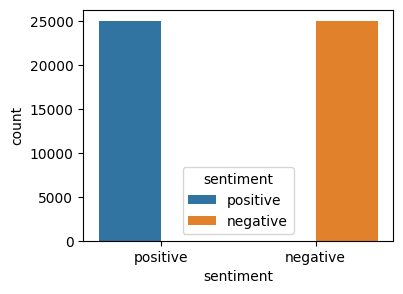

In [9]:
# Visualizing of positive/negative sentiments in dataset
plt.figure(figsize=(4,3))
sns.countplot(x='sentiment', data=df_reviews, hue='sentiment');

In [10]:
df_reviews['review'].iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

- We will need to deals with **punctuations**, brackets, HTML tags and numbers

## `STEP: DATA SPLIT`

In [11]:
df_reviews_train, df_reviews_test = train_test_split(df_reviews, test_size=valid_test_size, random_state=seed)
df_reviews_valid, df_reviews_test = train_test_split(df_reviews_test, test_size=0.5, random_state=seed)

print(df_reviews_train.shape, df_reviews_test.shape, df_reviews_valid.shape, sep=', ')

(40000, 2), (5000, 2), (5000, 2)


## `STEP: DATA LOADING AND PRE-PROCESSING`

In [12]:
## raw_text ->     Tokenizer     ->       Vocabulary     ->   CustomDataset
##              (string_tokens)       (numerical_tokens)     (Ready_for_model)

In [13]:
p='''
## OR you can use spacy tonkenizer or whatever you want.
class Tokenizer:
    def __init__(self, stemmer=True, html_tags_regex=True, punctuations_regex=True, words_contains_numbers_regex=True,
                 urls_regex=True, multi_space_regex=True, stopwords_regex=True):

        # for stemming step
        self.stemmer = PorterStemmer() if stemmer else None
        # for html tags
        self.html_tags_regex = re.compile(r'<[^>]+>') if html_tags_regex else None
        # for punctuations
        self.punctuations_regex = re.compile(r'[^a-z0-9\s]+') if punctuations_regex else None
        # for words that contains numbers like f4g
        self.words_contains_numbers_regex = re.compile(r'\w*\d+\w*') if words_contains_numbers_regex else None
        # for urls and links
        self.urls_regex = re.compile(r'https?://(?:www\.)?\S+|www\.\S+') if urls_regex else None
        # for multiple spaces and newlines
        self.multi_space_regex = re.compile(r'\n+|\s+') if multi_space_regex else None
        # for stopwords
        if stopwords_regex:
            # Define a list of negative verbs to remove
            negative_verbs = {'don', "don't", 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
                              "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'not', "n't", 'mustn', "mustn't", 'needn', "needn't",
                              'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"}
            # Remove negative verbs
            self.filtered_stop_words = [word for word in stopwords.words('english') if word not in negative_verbs]
            # self.stopwords_regex = re.compile(r'\b(' + r'|'.join(filtered_stop_words) + r')\b\s*')
        # else: self.stopwords_regex = None
        else: self.filtered_stop_words = []

    def sentence_tokenizing(self, input_text:str):

        text = input_text.lower()

        if self.html_tags_regex:
            text = self.html_tags_regex.sub(' ', text)

        if self.urls_regex:
            text = self.urls_regex.sub(' ', text)

        if self.punctuations_regex:
            text = self.punctuations_regex.sub('', text)

        if self.words_contains_numbers_regex:
            text = self.words_contains_numbers_regex.sub(' ', text)

        if self.multi_space_regex:
            text = self.multi_space_regex.sub(' ', text)

        text_tokens = text.split()

        text_tokens = [self.stemmer.stem(word) for word in text_tokens] if self.stemmer else text_tokens

        text_tokens = [token for token in text_tokens if token not in self.filtered_stop_words] if self.filtered_stop_words else text_tokens

        return text_tokens


    def __call__(self, input_text:str):
        return self.sentence_tokenizing(input_text)


    def word_tokenizing(self, input_word:str, stemming=True):

        word = input_word.lower().replace(' ', '')

        if self.html_tags_regex:
            if self.html_tags_regex.search(word):
                return ''

        if self.urls_regex:
            if self.urls_regex.search(word):
                return ''

        if self.punctuations_regex:
            if self.punctuations_regex.search(word):
                return ''

        if self.punctuations_regex:
            word = self.punctuations_regex.sub('', word)

        if self.words_contains_numbers_regex:
            if self.words_contains_numbers_regex.search(word):
                return ''

        if stemming:
            if self.stemmer:
                word = self.stemmer.stem(word)

        if self.filtered_stop_words:
            if word in self.filtered_stop_words:
                return ''

        return word
        '''

In [14]:
class spacy_tokenizer():
    def __init__(self):
        self.spacy_eng = spacy.load("en_core_web_sm")

    def __call__(self, text):
        return [tok.text.lower() for tok in self.spacy_eng.tokenizer(text)]

In [15]:
class Vocabulary:
    def __init__(self, callable_tokenizer=None, max_freq=3, unk=True, sos=False, eos=False):

        self.sos = sos
        self.eos = eos
        self.unk = unk
        if callable_tokenizer:
            self.callable_tokenizer = callable_tokenizer
        else:
            self.callable_tokenizer = spacy_tokenizer()

        self.stoi = {"<PAD>": 0}
        if self.unk:
            self.stoi['<UNK>'] = len(self.stoi)
        if self.sos:
            self.stoi['<SOS>'] = len(self.stoi)
        if self.eos:
            self.stoi['<EOS>'] = len(self.stoi)
        
    def __len__(self):
        return len(self.stoi)

    def get_vocabulary(self):
        return self.stoi

    def add_token(self, token_name: str):
        if token_name not in self.stoi:
            self.stoi[token_name] = len(self.stoi)

    def build_vocabulary(self, sentences_list):
        if type(sentences_list[0]) != str:
            ## ex: [['eating', 'apples'], ['eating', 'oranges']]
            sentences_list = [' '.join(sen) for sen in sentences_list]

        word_counts = Counter()
        for sentence in sentences_list:
            tokens = self.callable_tokenizer(sentence)
            word_counts.update(tokens)

        # Filter words with mox_freq or more occurrences
        filtered_words = [word for word, count in word_counts.items() if count >= 3]
        for word in filtered_words:
            if word not in self.stoi:
                self.stoi[word] = len(self.stoi)

    def get_numerical_tokens(self, text: str):
        tokens = self.callable_tokenizer(text)
        # tokens.insert(0, '<SOS>') if self.sos else None
        # tokens.append('<EOS>') if self.eos else None
        unk_id = self.stoi.get('<UNK>', None)
        return [self.stoi.get(word, unk_id) for word in tokens]

    def __call__(self, text: str):
        return self.get_numerical_tokens(text)

    def tokens_to_text(self, tokens_list):
        keys = list(self.stoi.keys())
        values = list(self.stoi.values())

        return ' '.join([keys[values.index(token)] for token in tokens_list])

In [16]:
class Custom_Dataset(Dataset):

    def __init__(self, sentences_list, labels_text, callable_final_vocabulary: Vocabulary, classes_dict: dict, maxlen):

        super(Custom_Dataset, self).__init__()
        self.raw_sentences = sentences_list
        self.labels_text = labels_text
        self.callable_final_vocabulary = callable_final_vocabulary
        self.classes_dict = classes_dict
        self.maxlen = maxlen

    def __len__(self):
        return len(self.raw_sentences)

    def __getitem__(self, index):
        text, label_text = self.raw_sentences[index], self.labels_text[index]

        label = self.classes_dict[label_text]
        num_tokens = self.callable_final_vocabulary(text)

        ## You will need to set sos, eos for vocab first
        num_tokens = [self.callable_final_vocabulary.get_vocabulary().get('<SOS>', None)] + num_tokens + [self.callable_final_vocabulary.get_vocabulary().get('<EOS>', None)]
        num_tokens = [tk for tk in num_tokens if tk is not None]
        num_tokens = num_tokens[:self.maxlen] if len(num_tokens)>self.maxlen else num_tokens
        
        return torch.tensor(num_tokens), torch.tensor(label).float()


In [17]:
class MYCollate():
    def __init__(self, batch_first=True, pad_value=0):
        self.pad_value = pad_value
        self.batch_first = batch_first

    def __call__(self, data):
        stentences = [ex[0] for ex in data]
        labels = torch.tensor([ex[1] for ex in data])

        padded_stentences = nn.utils.rnn.pad_sequence(stentences, batch_first=self.batch_first,
                                                      padding_value=self.pad_value)
        return padded_stentences, labels

# def get_dataloader(sentences_list, labels_list, callable_final_vocab:Vocabulary, classes_dict,
#                    collate_batch_first, colate_padding_side,
#                    batch_size, shuffle, num_workers, pin_memory):

#     dataset = Custom_Dataset(sentences_list, labels_list, callable_final_vocab, classes_dict)

#     pad_value = callable_final_vocab.get_vocabulary().get('<PAD>', 0)

#     collate_fn = MYCollate(collate_batch_first, pad_value, colate_padding_side)

#     loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn,
#                         num_workers=num_workers, pin_memory=pin_memory)

#     return loader

In [19]:
# word_tokenizer = spacy_tokenizer_eng
vocab = Vocabulary(max_freq=max_freq, unk=True, sos=False, eos=False)
vocab.build_vocabulary(df_reviews_train['review'].values)

print(f'{len(vocab) = }')

len(vocab) = 52434


In [20]:
classes_dict = {'negative': 0, 'positive': 1}
train_ds = Custom_Dataset(df_reviews_train['review'].values, df_reviews_train['sentiment'].values,
                          callable_final_vocabulary=vocab, classes_dict=classes_dict, maxlen=maxlen)

valid_ds = Custom_Dataset(df_reviews_valid['review'].values, df_reviews_valid['sentiment'].values,
                          callable_final_vocabulary=vocab, classes_dict=classes_dict, maxlen=maxlen)

test_ds = Custom_Dataset(df_reviews_test['review'].values, df_reviews_test['sentiment'].values,
                          callable_final_vocabulary=vocab, classes_dict=classes_dict, maxlen=maxlen)

In [21]:
train_ds[2]

(tensor([ 62, 381, 382, 328, 383,  31,   1,  10, 201,  55, 382, 324,  23, 384,
         385,  61, 386, 387,  17, 182, 167,  42, 388, 187, 389, 390,  45, 391,
         392,  45, 329,  70,  13,  10, 328, 393,  61,  62, 394,  36, 395,  38,
          67,  45,  87,  62, 396, 397,  91, 398,  91,  62, 399, 400,  17, 401,
          23,  62, 402, 403,  42, 404, 405,  45, 406,  23,  91,  10, 328, 407,
         127, 408,  10, 409, 410,  10, 411,  69,  58, 412, 413, 414,  17, 182,
         357, 415, 158,  10, 416, 417,   2, 418, 406,  23,  62, 419,  17, 306,
         328,  23]),
 tensor(1.))

In [22]:
mycollate = MYCollate(batch_first=True, pad_value=0)
pin_memory = True if device == 'cuda' else False
num_workers = 4 if isKaggle else 2

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          collate_fn=mycollate, num_workers=num_workers,
                          generator=g, pin_memory=pin_memory)

valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False,
                          collate_fn=mycollate, num_workers=num_workers,
                          generator=g, pin_memory=pin_memory)

test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                         collate_fn=mycollate, num_workers=num_workers,
                         generator=g, pin_memory=pin_memory)

for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 100])
torch.Size([64])


Very useful late known INFO :)

  - As we all know at feedforward layers number of input features must be the same for all data that will go throu the model. input shape (Batch, features)



  - And for CNN layers all data that will go throu the model must have same channel length, but for each example in the batch must have same shapes(H,W). input shape (Batch,C,H,W)



  - And for RNN layers data in one batch must have same sequence_length but batches can have different sequence_lengths. input shape (Batch, sequence_length, embedding_features)



**The Difference between CNNs and RNNs is that when you pass image with different hight and width than that model was training on, you will get bad results or may be dims mismatched error (if not followed by global average pooling), but for RNNs things are different.**


### Form Embedding matrix step

In [23]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

with ZipFile(f'{base_dir}/glove.6B.zip') as file:
    file.extract('glove.6B.100d.txt')

--2024-11-04 20:22:01--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-04 20:22:01--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glove.6B.zip        100%[===================>] 822.24M  5.09MB/s    in 3m 3s   

2024-11-04 20:25:05 (4.50 MB/s) - 'glove.6B.zip' saved [862182613/862182613]



In [24]:
# form an embedding matrix form glove pre-trained embedding weights for my vocab
glove_embeddings_index = dict()
embedding_matrix = torch.zeros((len(vocab), embd_features))
vocab_dict = vocab.get_vocabulary()
found = 0

with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]

        # token = word_tokenizer.word_tokenizing(word, stemming=False)
        token = word
        if token:
            # print(word)
            idx = vocab_dict.get(token, 0)
            if idx:
                found += 1
                coefs = torch.tensor([float(value) for value in values[1:]])
                embedding_matrix[idx] = coefs
                # glove_embeddings_index[word] = coefs

print('Found %s words.' % found)
print("Embedding matrix shape: " ,embedding_matrix.shape)


Found 44254 words.
Embedding matrix shape:  torch.Size([52434, 100])


In [25]:
for x, y in test_loader:
    print('Before Embedding layer', x.shape, y.shape, sep='\t\t')
    emb = embedding_matrix[x]
    print('After Embedding layer\t', emb.shape, y.shape, sep='\t')
    break

Before Embedding layer		torch.Size([64, 100])		torch.Size([64])
After Embedding layer		torch.Size([64, 100, 100])	torch.Size([64])


## `STEP: MODELS TRAINING && Evaluation`

### Defining

In [26]:
## Helper
@torch.no_grad()
def loss_acc_loader(model, data_loader, device):
    model.eval()

    total_predicts = []
    total_targets = []
    total_class_loss = 0

    for data, labels in data_loader:
        data = data.to(device)
        labels = labels.view(-1,1).to(device)

        class_logits = model(data)

        total_class_loss += class_criterion(class_logits, labels).item()

        total_predicts.append((class_logits>=0.5).float())
        total_targets.append(labels)

    total_predicts = torch.concat(total_predicts)
    total_targets = torch.concat(total_targets)

    avg_class_loss = total_class_loss / len(data_loader)
    accuracy = (total_predicts == total_targets).float().mean().item()

    return avg_class_loss, accuracy, total_predicts, total_targets


def get_parameters_info(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad==True)
    nontrainable = sum(p.numel() for p in model.parameters() if p.requires_grad==False)

    return trainable, nontrainable

In [27]:
class Sentiment_LSTM(nn.Module):
    def __init__(self, embedding_matrix:torch.Tensor, lstm_hidden_size, lstm_layers, linear_hidden_size):
        super(Sentiment_LSTM, self).__init__()

        self.input_size = embedding_matrix.size(-1)
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_layers = lstm_layers
        self.linear_hidden_size = linear_hidden_size

        self.embedding_matrix = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.lstm_hidden_size,
                          num_layers=self.lstm_layers, batch_first=True)

        # We will use only the last hidden state of the last layer for the prediction
        self.fc = nn.Sequential(nn.Linear(self.lstm_hidden_size, self.linear_hidden_size),
                                nn.ReLU(), nn.Dropout(0.3))

        self.classifier = nn.Linear(self.linear_hidden_size, 1)

    def forward(self, x):
        h_0 = torch.zeros((self.lstm_layers, x.size(0), self.lstm_hidden_size)).to(device)
        c_0 = torch.zeros((self.lstm_layers, x.size(0), self.lstm_hidden_size)).to(device)

        embds = self.embedding_matrix(x)
        all_outputs, (h_final, c_final) = self.lstm(embds, (h_0, c_0))
        h_final_final_layer = h_final[-1,:,:]

        fc_out = self.fc(h_final_final_layer)

        output = self.classifier(h_final_final_layer)
        return nn.functional.sigmoid(output)

In [28]:
lstm_model = Sentiment_LSTM(embedding_matrix, lstm_hidden_size, lstm_layers, linear_hidden_size).to(device)
tr, nontr = get_parameters_info(lstm_model)
print(f"Total trainable parameters = {tr}\nTotal non-trainable parameters = {nontr}")

# class_criterion = nn.CrossEntropyLoss()  # Classification loss
class_criterion = nn.BCELoss()  # Classification loss

optim = torch.optim.Adam(lstm_model.parameters(), 0.001)

Total trainable parameters = 5641993
Total non-trainable parameters = 0


### Training Loop

In [29]:
# ## overfit one-batch

# x_batch, y_batch = next(iter(train_loader))
# data = x_batch.to(device)
# labels = y_batch.view(-1,1).to(device)
# epochs = 300
# for epoch in range(epochs):

#     class_logits = lstm_model(data)

#     loss = class_criterion(class_logits, labels)

#     optim.zero_grad()
#     loss.backward()
#     optim.step()

#     predictions = (class_logits>=0.5).float()
#     if (epoch+1) % 100 == 0:
#         print(f'Epoch {epoch+1}/{epochs}: ', end='\t')
#         print(f'Loss = {loss.item():.2f}', f'Accuracy = {(predictions==labels).sum()}')

In [30]:
total_batches = len(train_loader)
train_class_losses = []
val_class_losses = []

for epoch in range(epochs):
    lstm_model.train()  # Set the model to training mode

    print(f'Epoch {epoch+1}/{epochs}: ', end='\n')
    for batch_idx, (data, labels) in enumerate(train_loader):

        data = data.to(device)
        labels = labels.view(-1,1).to(device)

        class_logits = lstm_model(data)

        loss = class_criterion(class_logits, labels)

        optim.zero_grad()
        loss.backward()
        optim.step()

    # Running model on the entire train and validation dataset after each epoch
    train_class_loss, train_accuracy, _, _ = loss_acc_loader(lstm_model, train_loader, device)
    train_class_losses.append(train_class_loss)
    print(f' Train: Class Loss {train_class_loss:.4f}, Accuracy {train_accuracy*100:.2f}%')

    val_class_loss, val_accuracy, _, _ = loss_acc_loader(lstm_model, valid_loader, device)
    val_class_losses.append(val_class_loss)
    print(f'  Validation: Class Loss {val_class_loss:.4f}, Accuracy {val_accuracy*100:.2f}%')

Epoch 1/30: 
 Train: Class Loss 0.6937, Accuracy 49.90%
  Validation: Class Loss 0.6936, Accuracy 50.02%
Epoch 2/30: 
 Train: Class Loss 0.3118, Accuracy 87.16%
  Validation: Class Loss 0.3895, Accuracy 82.60%
Epoch 3/30: 
 Train: Class Loss 0.2032, Accuracy 92.99%
  Validation: Class Loss 0.3975, Accuracy 83.36%
Epoch 4/30: 
 Train: Class Loss 0.1071, Accuracy 97.14%
  Validation: Class Loss 0.4249, Accuracy 82.92%
Epoch 5/30: 
 Train: Class Loss 0.0631, Accuracy 98.69%
  Validation: Class Loss 0.5029, Accuracy 81.74%
Epoch 6/30: 
 Train: Class Loss 0.0308, Accuracy 99.36%
  Validation: Class Loss 0.6811, Accuracy 82.00%
Epoch 7/30: 
 Train: Class Loss 0.0231, Accuracy 99.58%
  Validation: Class Loss 0.7483, Accuracy 80.64%
Epoch 8/30: 
 Train: Class Loss 0.0154, Accuracy 99.74%
  Validation: Class Loss 0.8954, Accuracy 80.76%
Epoch 9/30: 
 Train: Class Loss 0.0148, Accuracy 99.74%
  Validation: Class Loss 1.0519, Accuracy 81.04%
Epoch 10/30: 
 Train: Class Loss 0.0140, Accuracy 99.76

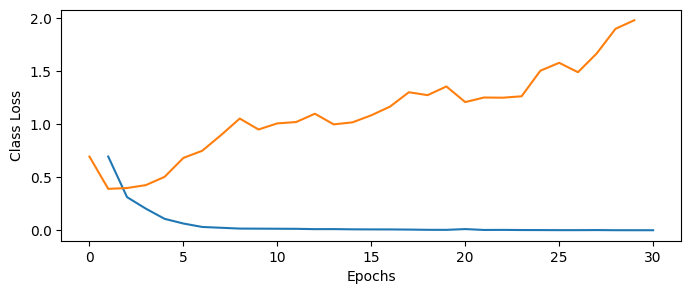

In [31]:
plt.figure(figsize=(8, 3))
plt.plot([ep+1 for ep in range(len(train_class_losses))], train_class_losses, val_class_losses)
plt.xlabel('Epochs')
plt.ylabel('Class Loss')
plt.show()

### Evaluation

In [32]:
test_class_loss, test_accuracy, _, _ = loss_acc_loader(lstm_model, test_loader, device)

print(f'Test: Class Loss {test_class_loss:.4f}, Accuracy {test_accuracy*100:.2f}%')

Test: Class Loss 1.9097, Accuracy 81.04%


### Saving

In [33]:
model_states = {'optim_state': optim.state_dict(),
                'class_dict': classes_dict,
                # 'Tokenizer': word_tokenizer,
                'vocabulary': vocab,
                'loss_tr': train_class_loss,
                'loss_ts': test_class_loss}

torch.save(model_states, f'{base_dir}/lstm_model_states.pt')
## Save Entire Model
torch.save(lstm_model, f'{base_dir}/lstm_model.bin')